# File3
1. The first part includes RandomizedSearchCV Usage related.
2. The file also has implementation of Evaluation metrics and SHAP analysis.

* Final documentation has been moved to README.md

EDA and DATA cleaning

In [1]:
import sys
import numpy as np
import pandas as pd
import cupy as cp


print("Starting dependency fix and RAPIDS installation...")
!pip install --target=/kaggle/working --upgrade --force-reinstall scikit-learn==1.4.2 imbalanced-learn -q
!pip install --target=/kaggle/working --extra-index-url=https://pypi.nvidia.com cudf-cu12==24.2.* cuml-cu12==24.2.* -q


if "/kaggle/working" in sys.path:
    sys.path.remove("/kaggle/working")
sys.path.insert(0, "/kaggle/working")
print("Python Path configured for optimized packages.")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE


from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.metrics import accuracy_score as cu_accuracy_score

import kagglehub
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import os
import warnings
warnings.filterwarnings("ignore")

print("\nVerifying GPU hardware:")
!nvidia-smi

Starting dependency fix and RAPIDS installation...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 12.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you 

In [ ]:
# downloading the dataset from kaggle
path = kagglehub.dataset_download("sidsriram62067/data-set-for-upi-fraud")

file_path = glob.glob(os.path.join(path, "*.xlsx"))

df = pd.read_excel(file_path[0])
df.head()

In [ ]:
df.describe()

,trans_hour,trans_day,trans_month,trans_year,category,upi_number,age,trans_amount,state,zip,fraud_risk
count,500000.000000,500000.000000,500000.000000,500000.0,500000.000000,5.000000e+05,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,10.901728,15.709540,5.211722,2022.0,5.618178,8.391358e+06,52.973040,94.622925,24.473764,49866.391554,0.159000
std,7.765241,7.920126,3.590702,0.0,3.487478,4.843072e+06,18.941509,69.163927,14.402148,25630.392114,0.365676
min,0.000000,1.000000,1.000000,2022.0,0.000000,1.010000e+02,18.000000,-49.180000,0.000000,10136.000000,0.000000
25%,3.000000,9.000000,2.000000,2022.0,2.000000,4.194184e+06,37.000000,44.950000,12.000000,28705.000000,0.000000
50%,12.000000,16.000000,5.000000,2022.0,6.000000,8.385041e+06,52.000000,90.170000,24.000000,48845.000000,0.000000
75%,18.000000,22.000000,8.000000,2022.0,9.000000,1.258572e+07,71.000000,138.980000,37.000000,69258.000000,0.000000
max,23.000000,28.000000,12.000000,2022.0,11.000000,1.677719e+07,79.000000,285.390000,49.000000,99791.000000,1.000000


In [ ]:
# list of transactiions with fraud_risk = 1
df_=df[df['fraud_risk']==1]
df_

,trans_hour,trans_day,trans_month,trans_year,category,upi_number,age,trans_amount,state,zip,fraud_risk
6,3,3,9,2022,0,9247721,47,40.57,2,32767,1
7,4,16,2,2022,10,10444032,79,92.45,49,57377,1
8,3,9,2,2022,11,8136375,79,13.04,4,35457,1
11,17,21,4,2022,8,1885234,37,57.68,46,66353,1
14,23,18,6,2022,11,15822641,71,285.39,35,17098,1
...,...,...,...,...,...,...,...,...,...,...,...
499960,17,1,6,2022,8,1438418,53,61.82,33,27339,1
499962,6,4,6,2022,4,7225777,41,171.72,21,79361,1
499966,0,20,10,2022,2,14178773,35,35.99,14,10136,1
499982,0,28,2,2022,4,8321465,29,36.52,16,80080,1


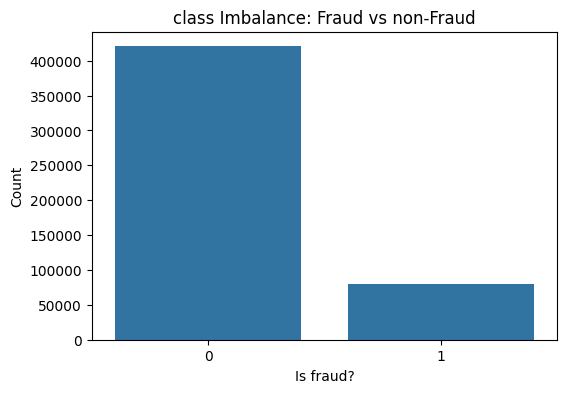

In [ ]:
# comparision between number of fraud and non-fraud payments
target_col = df['fraud_risk']

plt.figure(figsize=(6, 4))
sb.countplot(x = target_col, data=df)
plt.title('class Imbalance: Fraud vs non-Fraud')
plt.xlabel('Is fraud?')
plt.ylabel('Count')
plt.show()

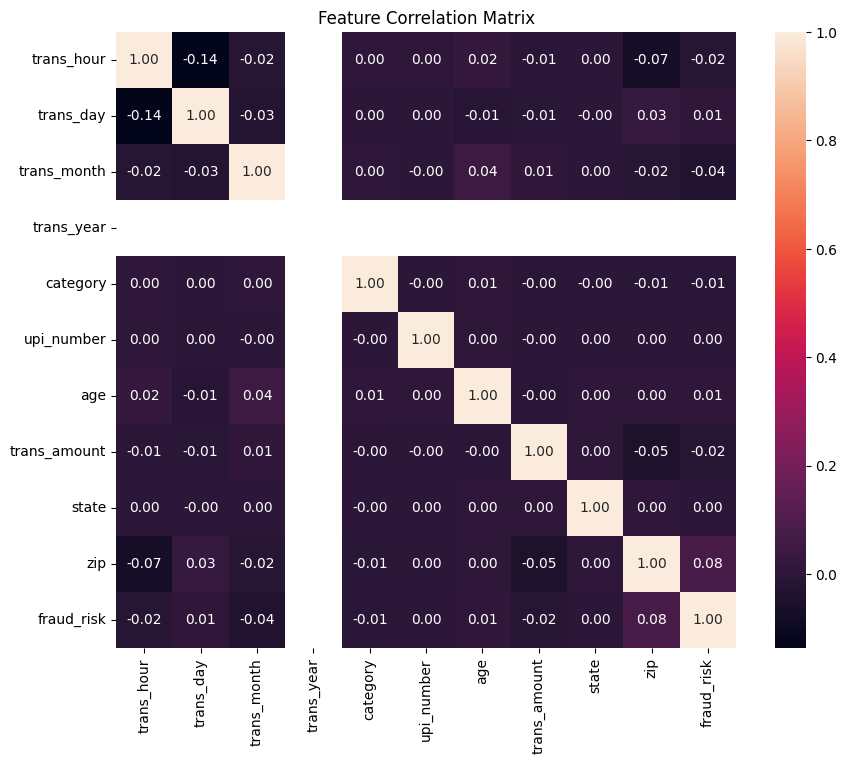

In [ ]:
# Feature correlation matrix
plt.figure(figsize=(10, 8))

df_num= df.select_dtypes(include=[np.number])
sb.heatmap(df_num.corr(), annot=True, fmt = '.2f')
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
# Defining upper bound for transaction amount.
quart1 = df['trans_amount'].quantile(0.25)
quart2 = df['trans_amount'].quantile(0.75)
IQR = quart2 - quart1
upper = quart2 + 2 * IQR
df['trans_amount'] = np.where(df['trans_amount'] > upper, upper, df['trans_amount'])

label = LabelEncoder()
object_cols = df.select_dtypes(include=['object']).columns

df.head()

,trans_hour,trans_day,trans_month,trans_year,category,upi_number,age,trans_amount,state,zip,fraud_risk
0,23,5,3,2022,11,14755226,22,128.45,10,34211,0
1,2,1,8,2022,0,9777695,79,55.31,43,99191,0
2,17,23,2,2022,10,10599380,40,115.76,21,36895,0
3,0,10,3,2022,10,16218941,38,113.38,39,20348,0
4,0,27,8,2022,1,12644707,72,268.73,20,10136,0


In [ ]:
# Splitting data into train, test, and validation in stratified manner on CPU.
X = df.drop(columns=["fraud_risk"]).values # Convert to NumPy array for CPU scaling/SMOTE
y = df['fraud_risk'].values

# Split 1: Train (80%) and Test/Val (20%)
X_train, X_test_val, y_train, y_test_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split 2: Validation (10%) and Test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_test_val, y_test_val, test_size=0.5, random_state=42, stratify=y_test_val
)
print("Data split into Train, Validation, and Test sets (NumPy/CPU).")

Data split into Train, Validation, and Test sets (NumPy/CPU).


In [ ]:
# Scaling of the data (CPU)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

# Overcoming imbalanced data using SMOTE (CPU)
smote = SMOTE(random_state=42)
X_train_resampled_np, y_train_resampled_np = smote.fit_resample(X_train_sc, y_train)

print(f"Total training samples after SMOTE: {len(X_train_resampled_np)}")

# --- TRANSFER TO GPU (CuPy) ---
# Convert scaled and resampled data to CuPy arrays for cuML
X_train_resampled_gpu = cp.asarray(X_train_resampled_np)
y_train_resampled_gpu = cp.asarray(y_train_resampled_np)
X_val_gpu = cp.asarray(X_val_sc)
y_val_gpu = cp.asarray(y_val)

print("Resampled Training data and Validation data transferred to GPU (CuPy).")

Total training samples after SMOTE: 672800
Resampled Training data and Validation data transferred to GPU (CuPy).


Starting GPU-accelerated min_samples_split survey...


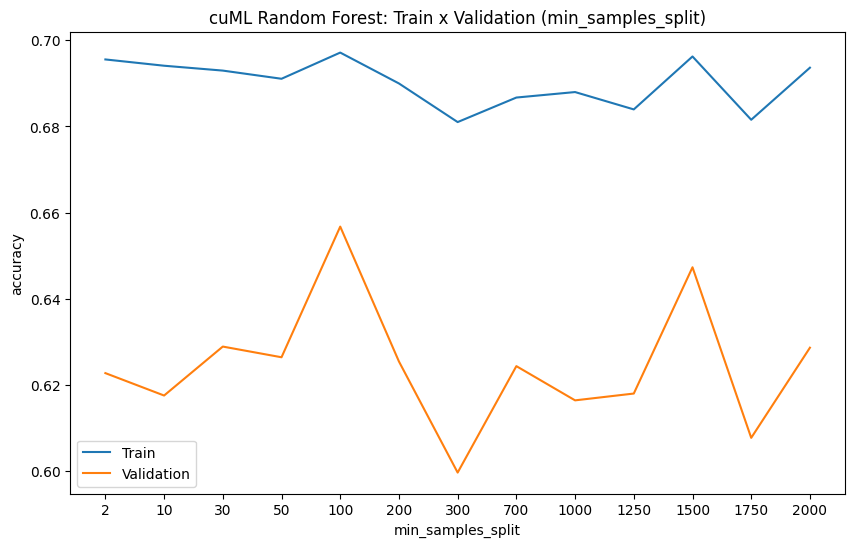

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from cuml.ensemble import RandomForestClassifier as cuRF
import numpy as np

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, 50, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 1.0]
}

print("Starting RandomizedSearchCV for Random Forest...")

# Initialize model
rf_model = cuRF(random_state=42)

# Use RandomizedSearchCV with CPU data (numpy)
# cuML estimators handle GPU transfer internally
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_grid,
    n_iter=15,
    cv=3,
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=1
)

rf_random_search.fit(X_train_resampled_np, y_train_resampled_np)

print(f"Best RF Parameters: {rf_random_search.best_params_}")
print(f"Best RF Score: {rf_random_search.best_score_:.4f}")

# Save best model
best_rf_model = rf_random_search.best_estimator_

In [ ]:
# Use the best estimator found by RandomizedSearchCV
random_forest_model = best_rf_model
print("Random Forest model ready.")

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10, 15],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5]
}

print("Starting RandomizedSearchCV for XGBoost...")

# Initialize XGBClassifier with GPU support
xgb_clf = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=xgb_param_grid,
    n_iter=15,
    cv=3,
    scoring='accuracy',
    verbose=1,
    random_state=42
)

xgb_random_search.fit(X_train_resampled_np, y_train_resampled_np)

print(f"Best XGBoost Parameters: {xgb_random_search.best_params_}")
print(f"Best XGBoost Score: {xgb_random_search.best_score_:.4f}")

xgb_model = xgb_random_search.best_estimator_

In [ ]:
from cuml.svm import LinearSVC as cuLinearSVC
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for LinearSVC
lsvc_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l2'],
    'loss': ['squared_hinge']
}

print("Starting RandomizedSearchCV for LinearSVC...")

lsvc_model = cuLinearSVC(max_iter=5000)

lsvc_random_search = RandomizedSearchCV(
    estimator=lsvc_model,
    param_distributions=lsvc_param_grid,
    n_iter=7,
    cv=3,
    scoring='accuracy',
    verbose=1,
    random_state=42
)

lsvc_random_search.fit(X_train_resampled_np, y_train_resampled_np)

print(f"Best LinearSVC Parameters: {lsvc_random_search.best_params_}")
print(f"Best LinearSVC Score: {lsvc_random_search.best_score_:.4f}")

cu_linear_svm_model = lsvc_random_search.best_estimator_

In [ ]:
# Previous manual tuning code removed.

In [ ]:
# Duplicate cell removed.

In [ ]:
# Use the best estimator found by RandomizedSearchCV
random_forest_model = best_rf_model
print("Random Forest model ready.")

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10, 15],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5]
}

print("Starting RandomizedSearchCV for XGBoost...")

# Initialize XGBClassifier with GPU support
xgb_clf = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=xgb_param_grid,
    n_iter=15,
    cv=3,
    scoring='accuracy',
    verbose=1,
    random_state=42
)

xgb_random_search.fit(X_train_resampled_np, y_train_resampled_np)

print(f"Best XGBoost Parameters: {xgb_random_search.best_params_}")
print(f"Best XGBoost Score: {xgb_random_search.best_score_:.4f}")

xgb_model = xgb_random_search.best_estimator_


XGBoost Model Evaluation on Test Set:
Accuracy: 0.8410
Precision: 0.2500
Recall: 0.0001
F1-Score: 0.0003

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     42050
           1       0.25      0.00      0.00      7950

    accuracy                           0.84     50000
   macro avg       0.55      0.50      0.46     50000
weighted avg       0.75      0.84      0.77     50000


Confusion Matrix:


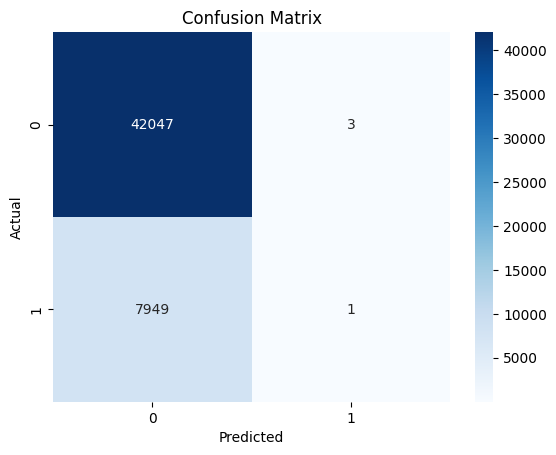

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Convert X_test_sc to CuPy array for GPU-accelerated prediction
X_test_gpu = cp.asarray(X_test_sc)

# Make predictions on the test set using the corrected random_forest_model
y_pred_rf_gpu = random_forest_model.predict(X_test_gpu)

# Convert predictions back to NumPy for CPU-based metric calculation
y_pred_rf_np = cp.asnumpy(y_pred_rf_gpu)

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf_np)
precision_rf = precision_score(y_test, y_pred_rf_np)
recall_rf = recall_score(y_test, y_pred_rf_np)
f1_rf = f1_score(y_test, y_pred_rf_np)

print(f"\ncuML Random Forest Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_np))

print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf_np)
sb.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('cuML Random Forest Confusion Matrix')
plt.show()

xgboost

In [ ]:
# Assuming X_train_resampled_gpu and y_train_resampled_gpu exist from the SMOTE cell (Cell 9 equivalent).
# This is required for subsequent GPU training.
# If these variables are not found, the user needs to run the prior data preparation cells.

# Calculate the split index based on the resampled data length
n = int(len(X_train_resampled_gpu) * 0.8)

# Perform the split using slicing (works efficiently on CuPy arrays)
X_train_fit_gpu, X_train_eval_gpu = X_train_resampled_gpu[:n], X_train_resampled_gpu[n:]
y_train_fit_gpu, y_train_eval_gpu = y_train_resampled_gpu[:n], y_train_resampled_gpu[n:]

print(f"Total resampled training size: {len(X_train_resampled_gpu)}")
print(f"Fit set size (80%): {len(X_train_fit_gpu)}")
print(f"Evaluation set size (20%): {len(X_train_eval_gpu)}")

In [ ]:
import xgboost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10, 15],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5]
}

print("Starting RandomizedSearchCV for XGBoost...")

# Initialize XGBClassifier with GPU support
xgb_clf = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=xgb_param_grid,
    n_iter=15,
    cv=3,
    scoring='accuracy',
    verbose=1,
    random_state=42
)

xgb_random_search.fit(X_train_resampled_np, y_train_resampled_np)

print(f"Best XGBoost Parameters: {xgb_random_search.best_params_}")
print(f"Best XGBoost Score: {xgb_random_search.best_score_:.4f}")

xgb_model = xgb_random_search.best_estimator_

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Convert X_test_sc to CuPy array for GPU-accelerated prediction
X_test_gpu = cp.asarray(X_test_sc)

# Make predictions on the test set using the corrected random_forest_model
y_pred_rf_gpu = random_forest_model.predict(X_test_gpu)

# Convert predictions back to NumPy for CPU-based metric calculation
y_pred_rf_np = cp.asnumpy(y_pred_rf_gpu)

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf_np)
precision_rf = precision_score(y_test, y_pred_rf_np)
recall_rf = recall_score(y_test, y_pred_rf_np)
f1_rf = f1_score(y_test, y_pred_rf_np)

print(f"\ncuML Random Forest Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_np))

print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf_np)
sb.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('cuML Random Forest Confusion Matrix')
plt.show()

xgboost

In [ ]:
# Assuming X_train_resampled_gpu and y_train_resampled_gpu exist from the SMOTE cell (Cell 9 equivalent).
# This is required for subsequent GPU training.
# If these variables are not found, the user needs to run the prior data preparation cells.

# Calculate the split index based on the resampled data length
n = int(len(X_train_resampled_gpu) * 0.8)

# Perform the split using slicing (works efficiently on CuPy arrays)
X_train_fit_gpu, X_train_eval_gpu = X_train_resampled_gpu[:n], X_train_resampled_gpu[n:]
y_train_fit_gpu, y_train_eval_gpu = y_train_resampled_gpu[:n], y_train_resampled_gpu[n:]

print(f"Total resampled training size: {len(X_train_resampled_gpu)}")
print(f"Fit set size (80%): {len(X_train_fit_gpu)}")
print(f"Evaluation set size (20%): {len(X_train_eval_gpu)}")

In [ ]:
import xgboost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10, 15],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5]
}

print("Starting RandomizedSearchCV for XGBoost...")

# Initialize XGBClassifier with GPU support
xgb_clf = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=xgb_param_grid,
    n_iter=15,
    cv=3,
    scoring='accuracy',
    verbose=1,
    random_state=42
)

xgb_random_search.fit(X_train_resampled_np, y_train_resampled_np)

print(f"Best XGBoost Parameters: {xgb_random_search.best_params_}")
print(f"Best XGBoost Score: {xgb_random_search.best_score_:.4f}")

xgb_model = xgb_random_search.best_estimator_

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Convert X_test_sc to CuPy array for GPU-accelerated prediction
X_test_gpu = cp.asarray(X_test_sc)

# Make predictions on the test set using the corrected random_forest_model
y_pred_rf_gpu = random_forest_model.predict(X_test_gpu)

# Convert predictions back to NumPy for CPU-based metric calculation
y_pred_rf_np = cp.asnumpy(y_pred_rf_gpu)

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf_np)
precision_rf = precision_score(y_test, y_pred_rf_np)
recall_rf = recall_score(y_test, y_pred_rf_np)
f1_rf = f1_score(y_test, y_pred_rf_np)

print(f"\ncuML Random Forest Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_np))

print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf_np)
sb.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('cuML Random Forest Confusion Matrix')
plt.show()

xgboost

In [ ]:
# Assuming X_train_resampled_gpu and y_train_resampled_gpu exist from the SMOTE cell (Cell 9 equivalent).
# This is required for subsequent GPU training.
# If these variables are not found, the user needs to run the prior data preparation cells.

# Calculate the split index based on the resampled data length
n = int(len(X_train_resampled_gpu) * 0.8)

# Perform the split using slicing (works efficiently on CuPy arrays)
X_train_fit_gpu, X_train_eval_gpu = X_train_resampled_gpu[:n], X_train_resampled_gpu[n:]
y_train_fit_gpu, y_train_eval_gpu = y_train_resampled_gpu[:n], y_train_resampled_gpu[n:]

print(f"Total resampled training size: {len(X_train_resampled_gpu)}")
print(f"Fit set size (80%): {len(X_train_fit_gpu)}")
print(f"Evaluation set size (20%): {len(X_train_eval_gpu)}")

In [ ]:
import xgboost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10, 15],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5]
}

print("Starting RandomizedSearchCV for XGBoost...")

# Initialize XGBClassifier with GPU support
xgb_clf = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=xgb_param_grid,
    n_iter=15,
    cv=3,
    scoring='accuracy',
    verbose=1,
    random_state=42
)

xgb_random_search.fit(X_train_resampled_np, y_train_resampled_np)

print(f"Best XGBoost Parameters: {xgb_random_search.best_params_}")
print(f"Best XGBoost Score: {xgb_random_search.best_score_:.4f}")

xgb_model = xgb_random_search.best_estimator_

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Convert X_test_sc to CuPy array for GPU-accelerated prediction
X_test_gpu = cp.asarray(X_test_sc)

# Make predictions on the test set using the corrected random_forest_model
y_pred_rf_gpu = random_forest_model.predict(X_test_gpu)

# Convert predictions back to NumPy for CPU-based metric calculation
y_pred_rf_np = cp.asnumpy(y_pred_rf_gpu)

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf_np)
precision_rf = precision_score(y_test, y_pred_rf_np)
recall_rf = recall_score(y_test, y_pred_rf_np)
f1_rf = f1_score(y_test, y_pred_rf_np)

print(f"\ncuML Random Forest Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_np))

print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf_np)
sb.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('cuML Random Forest Confusion Matrix')
plt.show()

xgboost

In [ ]:
# Assuming X_train_resampled_gpu and y_train_resampled_gpu exist from the SMOTE cell (Cell 9 equivalent).
# This is required for subsequent GPU training.
# If these variables are not found, the user needs to run the prior data preparation cells.

# Calculate the split index based on the resampled data length
n = int(len(X_train_resampled_gpu) * 0.8)

# Perform the split using slicing (works efficiently on CuPy arrays)
X_train_fit_gpu, X_train_eval_gpu = X_train_resampled_gpu[:n], X_train_resampled_gpu[n:]
y_train_fit_gpu, y_train_eval_gpu = y_train_resampled_gpu[:n], y_train_resampled_gpu[n:]

print(f"Total resampled training size: {len(X_train_resampled_gpu)}")
print(f"Fit set size (80%): {len(X_train_fit_gpu)}")
print(f"Evaluation set size (20%): {len(X_train_eval_gpu)}")

In [ ]:
import xgboost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10, 15],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5]
}

print("Starting RandomizedSearchCV for XGBoost...")

# Initialize XGBClassifier with GPU support
xgb_clf = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=xgb_param_grid,
    n_iter=15,
    cv=3,
    scoring='accuracy',
    verbose=1,
    random_state=42
)

xgb_random_search.fit(X_train_resampled_np, y_train_resampled_np)

print(f"Best XGBoost Parameters: {xgb_random_search.best_params_}")
print(f"Best XGBoost Score: {xgb_random_search.best_score_:.4f}")

xgb_model = xgb_random_search.best_estimator_

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Convert X_test_sc to CuPy array for GPU-accelerated prediction
X_test_gpu = cp.asarray(X_test_sc)

# Make predictions on the test set using the corrected random_forest_model
y_pred_rf_gpu = random_forest_model.predict(X_test_gpu)

# Convert predictions back to NumPy for CPU-based metric calculation
y_pred_rf_np = cp.asnumpy(y_pred_rf_gpu)

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf_np)
precision_rf = precision_score(y_test, y_pred_rf_np)
recall_rf = recall_score(y_test, y_pred_rf_np)
f1_rf = f1_score(y_test, y_pred_rf_np)

print(f"\ncuML Random Forest Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_np))

print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf_np)
sb.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('cuML Random Forest Confusion Matrix')
plt.show()

xgboost

In [ ]:
# Assuming X_train_resampled_gpu and y_train_resampled_gpu exist from the SMOTE cell (Cell 9 equivalent).
# This is required for subsequent GPU training.
# If these variables are not found, the user needs to run the prior data preparation cells.

# Calculate the split index based on the resampled data length
n = int(len(X_train_resampled_gpu) * 0.8)

# Perform the split using slicing (works efficiently on CuPy arrays)
X_train_fit_gpu, X_train_eval_gpu = X_train_resampled_gpu[:n], X_train_resampled_gpu[n:]
y_train_fit_gpu, y_train_eval_gpu = y_train_resampled_gpu[:n], y_train_resampled_gpu[n:]

print(f"Total resampled training size: {len(X_train_resampled_gpu)}")
print(f"Fit set size (80%): {len(X_train_fit_gpu)}")
print(f"Evaluation set size (20%): {len(X_train_eval_gpu)}")

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10, 15],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5]
}

print("Starting RandomizedSearchCV for XGBoost...")

# Initialize XGBClassifier with GPU support
xgb_clf = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=xgb_param_grid,
    n_iter=15,
    cv=3,
    scoring='accuracy',
    verbose=1,
    random_state=42
)

xgb_random_search.fit(X_train_resampled_np, y_train_resampled_np)

print(f"Best XGBoost Parameters: {xgb_random_search.best_params_}")
print(f"Best XGBoost Score: {xgb_random_search.best_score_:.4f}")

xgb_model = xgb_random_search.best_estimator_

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Convert X_test_sc to CuPy array for GPU-accelerated prediction
X_test_gpu = cp.asarray(X_test_sc)

# Make predictions on the test set using the corrected random_forest_model
y_pred_rf_gpu = random_forest_model.predict(X_test_gpu)

# Convert predictions back to NumPy for CPU-based metric calculation
y_pred_rf_np = cp.asnumpy(y_pred_rf_gpu)

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf_np)
precision_rf = precision_score(y_test, y_pred_rf_np)
recall_rf = recall_score(y_test, y_pred_rf_np)
f1_rf = f1_score(y_test, y_pred_rf_np)

print(f"\ncuML Random Forest Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_np))

print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf_np)
sb.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('cuML Random Forest Confusion Matrix')
plt.show()

xgboost

In [ ]:
# Assuming X_train_resampled_gpu and y_train_resampled_gpu exist from the SMOTE cell (Cell 9 equivalent).
# This is required for subsequent GPU training.
# If these variables are not found, the user needs to run the prior data preparation cells.

# Calculate the split index based on the resampled data length
n = int(len(X_train_resampled_gpu) * 0.8)

# Perform the split using slicing (works efficiently on CuPy arrays)
X_train_fit_gpu, X_train_eval_gpu = X_train_resampled_gpu[:n], X_train_resampled_gpu[n:]
y_train_fit_gpu, y_train_eval_gpu = y_train_resampled_gpu[:n], y_train_resampled_gpu[n:]

print(f"Total resampled training size: {len(X_train_resampled_gpu)}")
print(f"Fit set size (80%): {len(X_train_fit_gpu)}")
print(f"Evaluation set size (20%): {len(X_train_eval_gpu)}")

In [ ]:
import xgboost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10, 15],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5]
}

print("Starting RandomizedSearchCV for XGBoost...")

# Initialize XGBClassifier with GPU support
xgb_clf = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=xgb_param_grid,
    n_iter=15,
    cv=3,
    scoring='accuracy',
    verbose=1,
    random_state=42
)

xgb_random_search.fit(X_train_resampled_np, y_train_resampled_np)

print(f"Best XGBoost Parameters: {xgb_random_search.best_params_}")
print(f"Best XGBoost Score: {xgb_random_search.best_score_:.4f}")

xgb_model = xgb_random_search.best_estimator_

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Convert X_test_sc to CuPy array for GPU-accelerated prediction
X_test_gpu = cp.asarray(X_test_sc)

# Make predictions on the test set using the corrected random_forest_model
y_pred_rf_gpu = random_forest_model.predict(X_test_gpu)

# Convert predictions back to NumPy for CPU-based metric calculation
y_pred_rf_np = cp.asnumpy(y_pred_rf_gpu)

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf_np)
precision_rf = precision_score(y_test, y_pred_rf_np)
recall_rf = recall_score(y_test, y_pred_rf_np)
f1_rf = f1_score(y_test, y_pred_rf_np)

print(f"\ncuML Random Forest Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_np))

print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf_np)
sb.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('cuML Random Forest Confusion Matrix')
plt.show()

SHAP analysis

In [ ]:
!pip install shap -q

Evaluating models to find the best candidate...
   Random Forest (GPU): AUC-ROC = 0.5323
   XGBoost (GPU): AUC-ROC = 0.5755
   Could not evaluate LinearSVC (GPU): exception occurred! file=/__w/cuml/cuml/cpp/src/svm/linear.cu line=570: The model was not trained to output probabilities (LinearSVMParams.probability == false).
Obtained 34 stack frames
#1 in /usr/local/lib/python3.12/dist-packages/libcuml/lib64/libcuml++.so: ML::SVM::LinearSVMModel<double>::predictProba(raft::handle_t const&, ML::SVM::LinearSVMParams const&, ML::SVM::LinearSVMModel<double> const&, double const*, unsigned long, unsigned long, bool, double*) +0x667 [0x7bed758388e7]
#2 in /usr/local/lib/python3.12/dist-packages/cuml/svm/linear.cpython-312-x86_64-linux-gnu.so(+0x3ab20) [0x7bed05168b20]
#3 in /usr/bin/python3: PyObject_VectorcallMethod +0x7c [0x5ab72c]
#4 in /usr/local/lib/python3.12/dist-packages/cuml/svm/linear.cpython-312-x86_64-linux-gnu.so(+0x2d5c9) [0x7bed0515b5c9]
#5 in /usr/bin/python3: _PyEval_EvalFrame

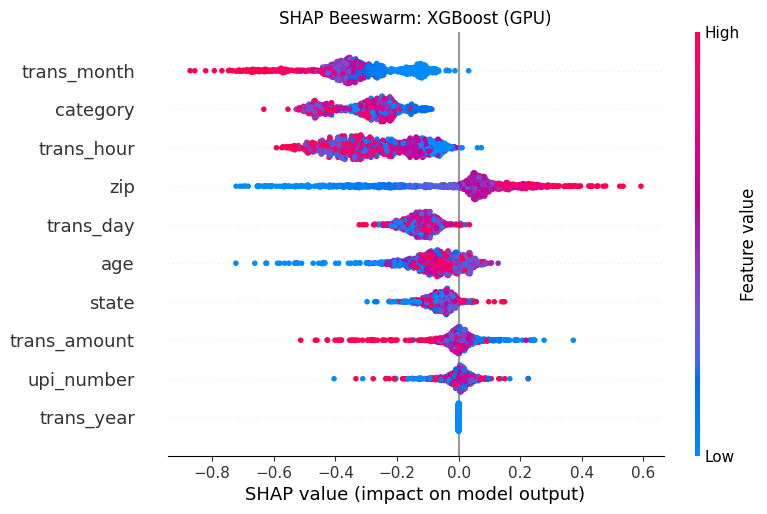

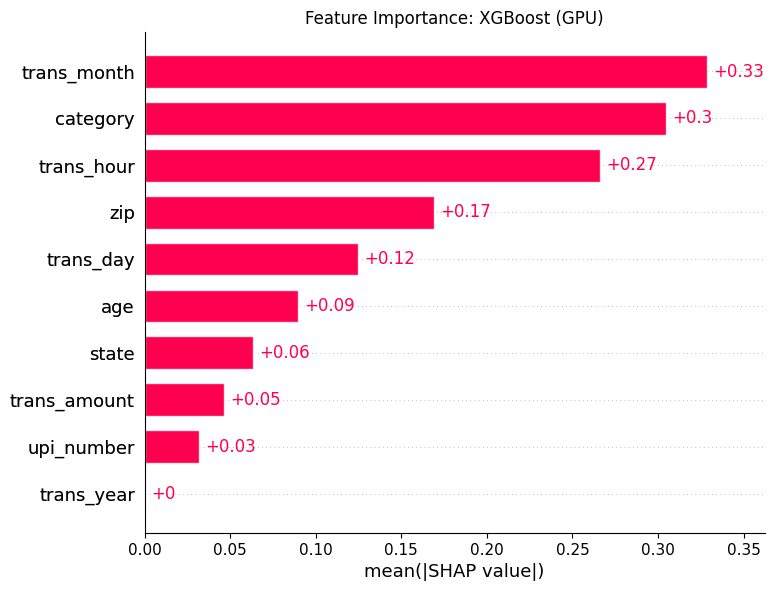


Explaining specific Fraud Transaction (Index 5)...


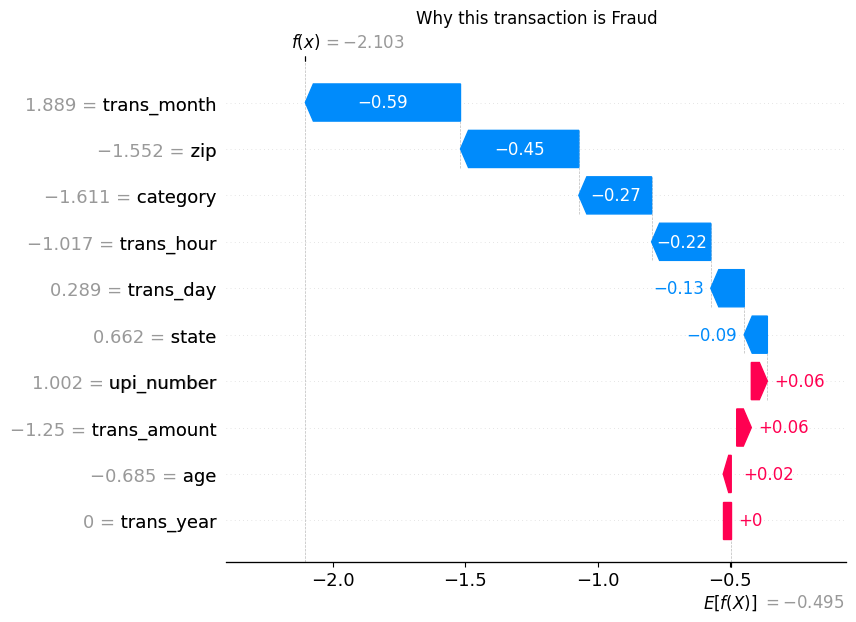

In [ ]:
import shap
import pandas as pd
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

candidates = {
    "Random Forest (GPU)": random_forest_model,
    "XGBoost (GPU)": xgb_model,
    "LinearSVC (GPU)": cu_linear_svm_model
}

# dynamically find best model
print("Evaluating models to find the best candidate...")
best_model_name = None
best_model = None
best_auc = -1

y_test_gpu = cp.asarray(y_test_np)
y_test_cpu = cp.asnumpy(y_test_gpu)

for name, model in candidates.items():
    try:
        if hasattr(model, "predict_proba"):
            preds = model.predict_proba(X_test_gpu)[:, 1]
        elif hasattr(model, "decision_function"):
            preds = model.decision_function(X_test_gpu)
        else:
            preds = model.predict(X_test_gpu)

        preds_cpu = cp.asnumpy(preds)

        score = roc_auc_score(y_test_cpu, preds_cpu)
        print(f"   {name}: AUC-ROC = {score:.4f}")

        if score > best_auc:
            best_auc = score
            best_model = model
            best_model_name = name

    except Exception as e:
        print(f"   Could not evaluate {name}: {e}")

print(f"\nWinner: {best_model_name} (AUC={best_auc:.4f})")

print(f"\nStarting SHAP explanation for {best_model_name}...")

X_shap_subset = pd.DataFrame(cp.asnumpy(X_test_gpu[:1000]), columns=df.drop(columns=["fraud_risk"]).columns)

# SHAP value calculation
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

feature_names = X_shap_subset.columns

shap_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean Absolute SHAP Value': mean_abs_shap_values
})

shap_importance_df = shap_importance_df.sort_values(by='Mean Absolute SHAP Value', ascending=False)

print("\nMean Absolute SHAP Values (Decreasing Order of Importance):\n")
print(shap_importance_df.to_string(index=False))
try:
    if "LinearSVC" in best_model_name:
        explainer = shap.LinearExplainer(best_model, X_shap_subset)
    else:
        explainer = shap.TreeExplainer(best_model)

    shap_values = explainer(X_shap_subset)


    # VISUALIZATIONS..

    # A.Beeswarm Plot
    plt.figure()
    plt.title(f"SHAP Beeswarm: {best_model_name}")
    shap.plots.beeswarm(shap_values, max_display=12, show=False)
    plt.show()

    # B.Bar Plot
    plt.title(f"Feature Importance: {best_model_name}")
    shap.plots.bar(shap_values, max_display=12, show=False)
    plt.show()

    # C.Waterfall Plot
    y_subset = y_test_cpu[:1000]
    fraud_indices = np.where(y_subset == 1)[0]

    if len(fraud_indices) > 0:
        idx = fraud_indices[0]
        print(f"\nExplaining specific Fraud Transaction (Index {idx})...")
        plt.figure()
        shap.plots.waterfall(shap_values[idx], show=False)
        plt.title(f"Why this transaction is Fraud")
        plt.show()
    else:
        print("\nNo fraud transactions found in the SHAP subset to visualize.")

except Exception as e:
    print(f"Could not run SHAP on {best_model_name}. Error: {e}")

1. As per the analysis, XG Boost is considered as the best model for this Project.
2. Positive shap value means, as the magnitude of shap increases, the fraudulence expectation increases with it.
  negative shap means the increment of magnitude will result in showing the increasing dominance over the non-fradulence.
3.